In [13]:
import pandas as pd
# 读取两个数据文件
df1 = pd.read_csv('002-气象-lanshanzui-merged.csv')
df2 = pd.read_csv('003-MCD18C2_061_20241027_插值填充_lanshanzui.csv')

# 将date列转换为datetime格式
df1['date'] = pd.to_datetime(df1['date'])
df2['date'] = pd.to_datetime(df2['date'])

# 按date列合并两个数据框
merged_df = pd.merge(df1, df2, on='date', how='outer')

# 按日期排序
merged_df = merged_df.sort_values('date')

# 保存合并后的数据
merged_df.to_csv('20-merged_all_data.csv', index=False)


In [14]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 删除不需要的列
columns_to_drop = ['time', 'area', 'aqi', 'aqiLevel', 'aqiInfo', 'density_mean', 'density_lower', 'density_upper']
df = df.drop(columns=columns_to_drop)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)


In [15]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加风力大于等于4级的特征
df['wind_power_num'] = df['wind_power'].map(lambda x: 1 if x == '微风' else float(x.replace('级','')))
df['strong_wind'] = (df['wind_power_num'] >= 4).astype(int)

# 删除wind_power列
df = df.drop('wind_power', axis=1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)


In [16]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建北风和西北风的one-hot编码
df['wind_north'] = df['wind_direction'].apply(lambda x: 1 if x in ['北风', '西北风'] else 0)

# 删除wind_direction列
df = df.drop('wind_direction', axis=1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [17]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

# 创建大雨和暴雨的合并特征
df['weather_heavy_rain'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and ('大雨' in split_weather(x) or '暴雨' in split_weather(x)) else 0)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [18]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建温度大于25度的one-hot编码
df['temperature_high'] = (df['temperature'] > 25).astype(int)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

In [19]:
import numpy as np
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

# 创建天气权重
df['weather_weight'] = df['weather'].apply(lambda x: 1.0 if '晴' in split_weather(x) else (0.7 if '多云' in split_weather(x) else 0))

# 打印温度的最大值和最小值,检查数据
print("温度范围:", df['temperature'].min(), "-", df['temperature'].max())

# 计算温度效应 (使用25度作为阈值)
temp_effect = np.where(df['temperature'] > 25,
                      (df['temperature'] - 25) / (35 - 25), # 使用固定的温度范围,避免分母过大
                      0)

# 打印温度效应的统计信息
print("温度效应统计:")
print(pd.Series(temp_effect).describe())

# 创建天气-温度综合指数
df['weather_temp_index'] = df['weather_weight'] * temp_effect

# 打印最终指数的统计信息
print("天气-温度综合指数统计:")
print(df['weather_temp_index'].describe())

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

温度范围: 1.33 - 33.78
温度效应统计:
count    1308.000000
mean        0.071129
std         0.168039
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.878000
dtype: float64
天气-温度综合指数统计:
count    1308.000000
mean        0.040246
std         0.110729
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.614600
Name: weather_temp_index, dtype: float64


In [20]:
# 读取合并后的数据
df = pd.read_csv('20-merged_all_data.csv')

# 创建组合特征
# 1. 营养盐比值 (N/P比)
df['NP_ratio'] = df['TN'] / df['TP']

# 2. 温氧指数 (温度和溶解氧的乘积)
df['temp_oxygen_index'] = df['temperature'] * df['oxygen']

# 3. 富营养化指数 (基于氮磷和有机物)
df['eutrophication_index'] = (df['TN'] + df['TP'] + df['permanganate']) / 3

# 4. 水质综合指数 (pH、浊度和电导率的加权组合)
df['water_quality_index'] = (df['pH'] * 0.3 + df['turbidity'] * 0.4 + df['conductivity'] * 0.3)

# 5. 氮磷污染指数
df['nutrient_pollution_index'] = df['NH'] * df['TP']

# 6. 温度与pH的交互作用
df['temp_ph_interaction'] = df['temperature'] * df['pH']

# 7. 氨氮与总氮比值 (反映无机氮占比)
df['NH_TN_ratio'] = df['NH'] / df['TN']

# 8. 溶解氧饱和度指数 (考虑温度影响)
df['oxygen_saturation_index'] = df['oxygen'] / (14.652 - 0.41022 * df['temperature'] + 0.007991 * df['temperature']**2 - 0.000077774 * df['temperature']**3)

# 9. 营养盐限制因子 (最小营养盐法则)
df['nutrient_limitation'] = np.minimum(df['TN']/7.2, df['TP']/1)

# 10. 光照-浊度指数 (假设有光照数据，这里用浊度的倒数近似)
df['light_turbidity_index'] = 1 / (df['turbidity'] + 1)

# 保存处理后的数据
df.to_csv('20-merged_all_data.csv', index=False)

请你按照建议修改：

将TCN模型改为LSTM模型，并保持防止过拟合的特性和藻密度特征的权重增强。以下是主要的更改：

```python:root\Download\Modis-algae-aliyun\AlgaeBloomForecast-20241107\08-LSTM-单独计算藻密度-dropout-better+his-density-05.ipynb
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # 特征权重层，为藻密度相关特征赋予更大权重
        initial_weights = torch.ones(input_size)
        density_indices = [i for i, name in enumerate(features) if 'density' in name]
        initial_weights[density_indices] = 2.0  # 藻密度特征权重加倍
        self.feature_weights = nn.Parameter(initial_weights)
        
        # 批归一化层
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # LSTM层
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True  # 使用双向LSTM
        )
        
        # 注意力机制
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=4)  # *2是因为双向LSTM
        
        # 全连接层，使用多层防止过拟合
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Linear(hidden_size // 2, output_size)
        )
        
        # 残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        # 初始化权重
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        # 批归一化
        batch_size, seq_len, features = weighted_x.size()
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        weighted_x = weighted_x.transpose(1, 2)
        
        # LSTM处理
        lstm_out, _ = self.lstm(weighted_x)
        
        # 注意力机制
        lstm_out = lstm_out.transpose(0, 1)
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out.transpose(0, 1)
        
        # 取最后一个时间步
        out = attn_out[:, -1, :]
        
        # 全连接层
        out = self.fc_layers(out)
        
        # 残差连接
        residual = self.residual(weighted_x[:, -1, :])
        out = out + residual
        
        return out
```

主要改动说明：

1. **模型架构改进**：
   - 将TCN替换为双向LSTM
   - 保留了多头注意力机制
   - 使用了更深的全连接层网络

2. **防止过拟合的技术**：
   - 使用Dropout（在LSTM层和全连接层）
   - 批归一化（BatchNorm）
   - 双向LSTM提供更丰富的特征表示
   - 残差连接
   - 正则化的权重初始化

3. **藻密度特征权重增强**：
   - 在feature_weights初始化时，为藻密度相关特征赋予更大的权重（2.0）
   - 通过batch_norm进行特征标准化

4. **其他优化**：
   - 使用Xavier初始化和正交初始化优化权重初始化
   - 多层全连接网络带有BatchNorm和Dropout
   - 保留了残差连接以帮助训练

使用这个模型时，其他代码（如train_lstm_model、evaluate_lstm_model等）可以保持不变，只需要在main函数中将TCNModel替换为LSTMModel：

```python
# 在main函数中替换模型初始化部分
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)
```

/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 22686 (\N{CJK UNIFIED IDEOGRAPH-589E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/3177089442.py:17: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.

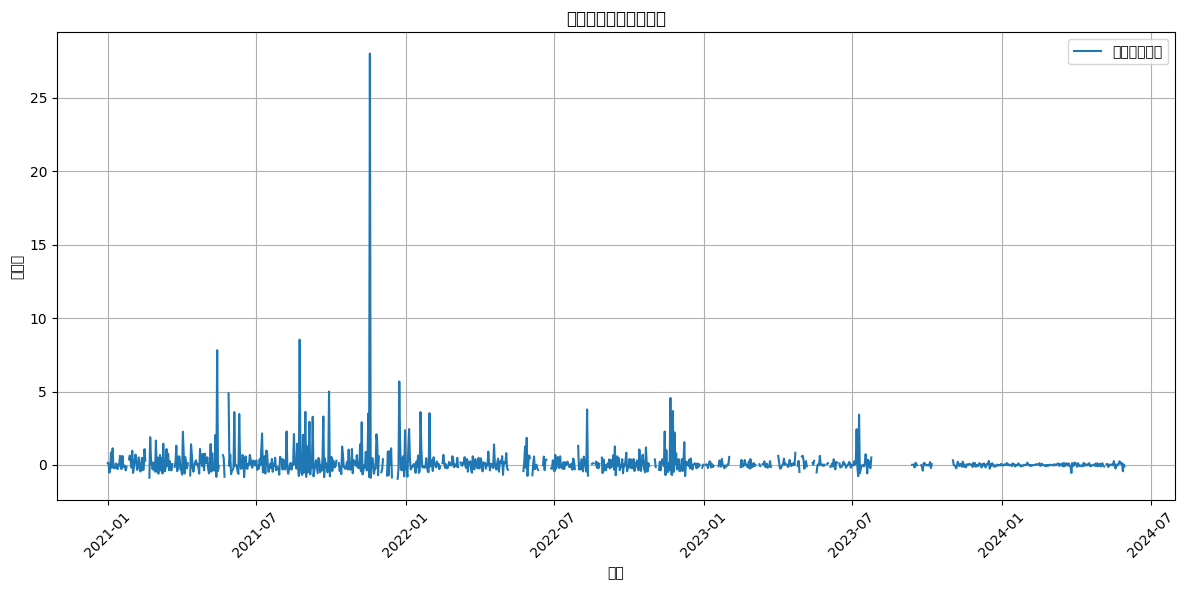


藻密度增长率统计信息:
count    1027.000000
mean        0.158564
std         1.151961
min        -0.944892
25%        -0.164439
50%         0.000000
75%         0.182837
max        28.014222
Name: density_growth, dtype: float64


In [21]:
# 绘制藻密度的逐日增长率
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算逐日增长率
df['density_growth'] = (df['density'].shift(-1) - df['density']) / df['density']

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['density_growth'], label='藻密度增长率')
plt.title('藻密度逐日增长率变化')
plt.xlabel('日期')
plt.ylabel('增长率')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印增长率的基本统计信息
print("\n藻密度增长率统计信息:")
print(df['density_growth'].describe())


/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 22686 (\N{CJK UNIFIED IDEOGRAPH-589E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_18429/821629920.py:28: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_l

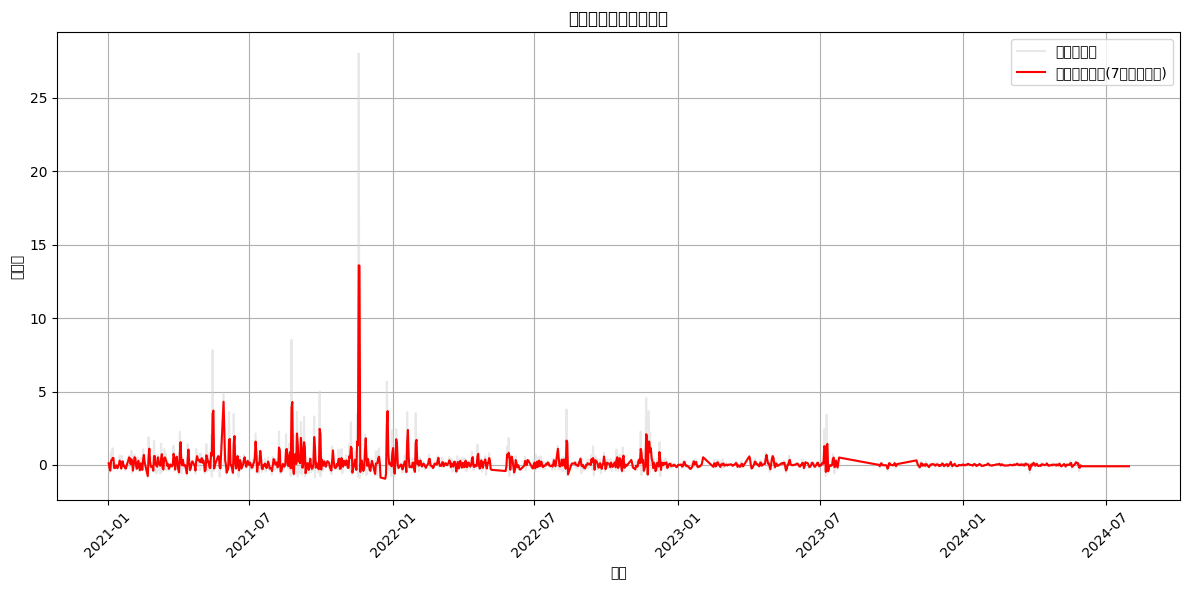


平滑后藻密度增长率统计信息:
count    1307.000000
mean        0.133886
std         0.709266
min        -0.938095
25%        -0.090426
50%         0.017425
75%         0.174390
max        13.595723
Name: density_growth_smoothed, dtype: float64


In [29]:
# 绘制藻密度的逐日增长率
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算逐日增长率
df['density_growth'] = (df['density'].shift(-1) - df['density']) / df['density']

# 对增长率的缺失值进行插值填充
df['density_growth'] = df['density_growth'].interpolate(method='linear')

# 使用移动平均平滑增长率
window_size = 2  # 3天移动平均
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()

# 对平滑后的缺失值进行插值填充
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['density_growth'], 'lightgray', label='原始增长率', alpha=0.5)
plt.plot(df.index, df['density_growth_smoothed'], 'r', label='平滑后增长率(7天移动平均)')
plt.title('藻密度逐日增长率变化')
plt.xlabel('日期')
plt.ylabel('增长率')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印平滑后增长率的基本统计信息
print("\n平滑后藻密度增长率统计信息:")
print(df['density_growth_smoothed'].describe())


## 更好的使用方式应该是在滑动窗口预测时动态创建序列：

数据集总长度: 1308
所有日期范围: 2021-01-01 00:00:00 到 2024-07-31 00:00:00
训练集截止日期: 2023-11-13 00:00:00
split_date是否在数据范围内: True

划分后:
训练集大小: 1046
测试集大小: 262
测试数据形状: (262, 26)
Epoch [5/300], Loss: 0.0067
Epoch [10/300], Loss: 0.0006
Epoch [15/300], Loss: 0.0041
Epoch [20/300], Loss: 0.0008
Epoch [25/300], Loss: 0.0010
Epoch [30/300], Loss: 0.0020
Epoch [35/300], Loss: 0.0002
Epoch [40/300], Loss: 0.0011
Epoch [45/300], Loss: 0.0006
Epoch [50/300], Loss: 0.0011
Epoch [55/300], Loss: 0.0011
Epoch [60/300], Loss: 0.0003
Epoch [65/300], Loss: 0.0033
Epoch [70/300], Loss: 0.0003
Epoch [75/300], Loss: 0.0006
Epoch [80/300], Loss: 0.0004
Epoch [85/300], Loss: 0.0001
Epoch [90/300], Loss: 0.0011
Epoch [95/300], Loss: 0.0002
Epoch [100/300], Loss: 0.0002
Epoch [105/300], Loss: 0.0002
Epoch [110/300], Loss: 0.0018
Epoch [115/300], Loss: 0.0004
Epoch [120/300], Loss: 0.0007
Epoch [125/300], Loss: 0.0007
Epoch [130/300], Loss: 0.0001
Epoch [135/300], Loss: 0.0003
Epoch [140/300], Loss: 0.0005
Epoch [145/300],

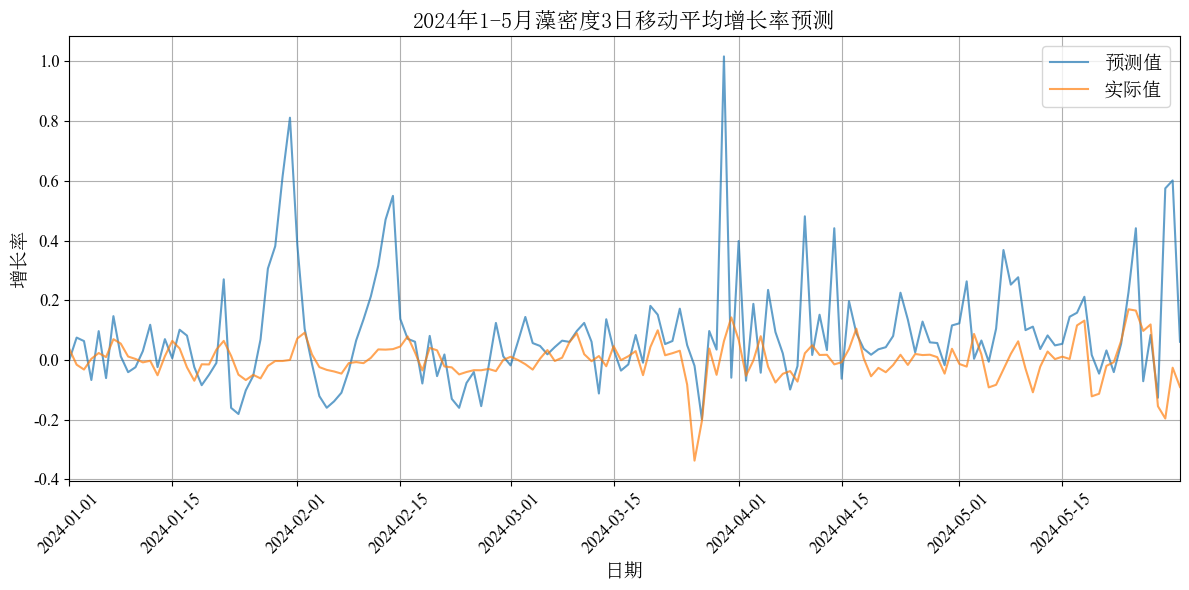

: 

In [48]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import logging
from torch.optim.lr_scheduler import OneCycleLR

# 设置字体
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimSun', 'DejaVu Sans']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False

chinese_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/SIMSUN.TTC', size=14)
english_font = fm.FontProperties(fname='/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241122/TIMES.TTF', size=14)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# 读取数据
df = pd.read_csv('20-merged_all_data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算3日移动平均增长率
df['density_growth'] = (df['density'].shift(-1) - df['density']) / df['density']
df['density_growth'] = df['density_growth'].interpolate(method='linear')
window_size = 2
df['density_growth_smoothed'] = df['density_growth'].rolling(window=window_size, center=True).mean()
df['density_growth_smoothed'] = df['density_growth_smoothed'].interpolate(method='linear')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

def create_sequence_for_date(data, date_index, seq_length):
    """为指定日期创建输入序列"""
    if date_index < seq_length:
        return None
    return data[date_index - seq_length:date_index]

# 数据预处理
features = ['temperature', 'pH', 'oxygen', 'permanganate', 'TN', 'conductivity', 
                        'turbidity', 'chla', 'density', 'density_growth', 'GMT_0000_PAR', 'GMT_0300_PAR', 
                        'GMT_0900_PAR', 'GMT_2100_PAR', 'MPAR', 'APAR', 'PPDI', 'PAI',
                        'eutrophication_index', 'temp_ph_interaction', 'wind_north',
                        'weather_heavy_rain', 'weather_temp_index', 'temperature_high',
                        'strong_wind', 'density_growth_smoothed']
data = df[features].values
# 处理缺失值
data = np.nan_to_num(data, nan=0)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 首先检查数据集的基本信息
print("数据集总长度:", len(df))
print("所有日期范围:", df.index.min(), "到", df.index.max())

# 使用最后20%的数据作为测试集
train_size = int(len(df) * 0.8)
split_date = df.index[train_size]

print("训练集截止日期:", split_date)
print("split_date是否在数据范围内:", split_date in df.index)

# 重新划分数据
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]
test_data = scaled_data[train_size:]

print("\n划分后:")
print("训练集大小:", len(train_dates))
print("测试集大小:", len(test_dates))
print("测试数据形状:", test_data.shape)

seq_length = 40

# 训练阶段
train_sequences = []
train_targets = []
for i in range(seq_length, train_size):
    seq = create_sequence_for_date(scaled_data, i, seq_length)
    if seq is not None:
        train_sequences.append(seq)
        train_targets.append(scaled_data[i, features.index('density_growth_smoothed')])

# 转换为PyTorch张量
X_train = torch.FloatTensor(train_sequences)
y_train = torch.FloatTensor(train_targets)

# 创建数据加载器
train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 初始化模型
model = LSTMModel(input_size=len(features), hidden_size=64, 
                 num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 300
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0:  # 每5个epoch输出一次
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# 预测阶段
model.eval()
predictions = []
actual_values = []
prediction_dates = []

current_sequence = scaled_data[train_size-seq_length:train_size]

with torch.no_grad():
    for i in range(len(test_data)):
        current_sequence_tensor = torch.FloatTensor(current_sequence).unsqueeze(0)
        pred = model(current_sequence_tensor)
        
        predictions.append(pred.item())
        actual_values.append(test_data[i, features.index('density_growth_smoothed')])
        
        current_sequence = np.vstack([
            current_sequence[1:],
            test_data[i]
        ])
        
        prediction_dates.append(test_dates[i])
        
        if i % 10 == 0:
            print(f"正在预测: {test_dates[i]}")

# 打印预测结果的长度
print(f"预测结果数量: {len(predictions)}")
print(f"实际值数量: {len(actual_values)}")

predictions_array = np.array(predictions).reshape(-1, 1)
actual_values_array = np.array(actual_values).reshape(-1, 1)

print(f"predictions_array shape: {predictions_array.shape}")
print(f"actual_values_array shape: {actual_values_array.shape}")

# 创建完整的特征数组
pred_full_features = np.zeros((len(predictions), len(features)))
actual_full_features = np.zeros((len(actual_values), len(features)))

print(f"pred_full_features shape: {pred_full_features.shape}")
print(f"actual_full_features shape: {actual_full_features.shape}")

# 将预测值和实际值放入对应的位置
density_growth_idx = features.index('density_growth_smoothed')
pred_full_features[:, density_growth_idx] = predictions_array.ravel()
actual_full_features[:, density_growth_idx] = actual_values_array.ravel()

# 反归一化
predictions = scaler.inverse_transform(pred_full_features)[:, density_growth_idx]
actual_values = scaler.inverse_transform(actual_full_features)[:, density_growth_idx]
# 绘制结果
plt.figure(figsize=(12, 6))

# 筛选2024年1-5月的数据
start_date = '2024-01-01'
end_date = '2024-05-31'
mask = (pd.to_datetime(prediction_dates) >= start_date) & (pd.to_datetime(prediction_dates) <= end_date)

# 绘制2024年1-5月的预测结果
plt.plot(pd.to_datetime(prediction_dates)[mask], predictions[mask], label='预测值', alpha=0.7)
plt.plot(pd.to_datetime(prediction_dates)[mask], actual_values[mask], label='实际值', alpha=0.7)

plt.title('2024年1-5月藻密度3日移动平均增长率预测', fontproperties=chinese_font, fontsize=16)
plt.xlabel('日期', fontproperties=chinese_font, fontsize=14)
plt.ylabel('增长率', fontproperties=chinese_font, fontsize=14)
plt.legend(prop=chinese_font)
plt.grid(True)

# 设置坐标轴刻度字体
ax = plt.gca()
plt.xticks(rotation=45)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(english_font)
plt.tick_params(axis='both', which='major', labelsize=12)

# 设置x轴时间范围
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

plt.tight_layout()
plt.show()
